<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**The first step is to establish that something is possible; then probability will occur - [Elon Musk](https://en.wikipedia.org/wiki/Elon_Musk)**

# Chapter 14 Analytical Methods

This book has focused on computational methods like simulation and resampling, but some of the problems we solved have analytic solutions that can be much faster.

I present some of these methods in this chapter, and explain how they work. At the end of the chapter, I make suggestions for integrating computational and analytic methods for exploratory data analysis.

## Normal Distributions

As a motivating example, let’s review the problem section 3 chapter 8:

`Suppose you are a scientist studying gorillas in a wildlife preserve. Having weighed 9 gorillas, you find sample mean x̄ = 90 kg and sample standard deviation, S = 7.5 kg. If you use x̄ to estimate the population mean, what is the standard error of the estimate?`

To answer that question, we need the sampling distribution of x̄. In Section 8.3 we approximated this distribution by simulating the experiment (weighing 9 gorillas), computing x̄ for each simulated experiment, and accumulating the distribution of estimates.

The result is an approximation of the sampling distribution. Then we use the sampling distribution to compute standard errors and confidence intervals:

1. The standard deviation of the sampling distribution is the standard error of the estimate; in the example, it is about 2.5 kg.
2. The interval between the 5th and 95th percentile of the sampling distribution is a 90% confidence interval. If we run the experiment many times, we expect the estimate to fall in this interval 90% of the time. In the example, the 90% CI is (86, 94) kg.

Now we’ll do the same calculation analytically. We take advantage of the fact that the weights of adult female gorillas are roughly normally distributed. Normal distributions have two properties that make them amenable for analysis: they are “closed” under linear transformation and addition. To explain what that means, I need some notation.


![alt text](Resources/Think_Stats/notebookpics/Nomal_transform.png) 

and in general if we draw n values of X and add them up, we have (3):

![alt text](Resources/Think_Stats/notebookpics/transformed_anal.png)

## Sampling Distributions

Now we have everything we need to compute the sampling distribution of x̄. Remember that we compute x̄ by weighing n gorillas, adding up the total weight, and dividing by n.

Assume that the distribution of gorilla weights, X, is approximately normal:

![alt text](Resources/Think_Stats/notebookpics/anal_sampling.png "Title")

using Equation 1 with a = 1/n.

The distribution of Z is the sampling distribution of x̄. The mean of Z is μ, which shows that x̄ is an unbiased estimate of μ. The variance of the sampling distribution is σ^2/n. 

What is then the standard deviation and therefore the standard error of the estimate?

In [ ]:
# Calculate it here

So the standard deviation of the sampling distribution, which is the standard error of the estimate, is σ/√n. In the example, σ is 7.5 kg and n is 9, so the standard error is 2.5 kg. That result is consistent with what we estimated by simulation, but much faster to compute!

We can also use the sampling distribution to compute confidence intervals. A 90% confidence interval for x̄ is the interval between the 5th and 95th percentiles of Z. Since Z is normally distributed, we can compute percentiles
by evaluating the inverse CDF.

There is no closed form for the CDF of the normal distribution or its inverse, but there are fast numerical methods and they are implemented in SciPy, as we saw in Section 5.2. thinkstats2 provides a wrapper function that makes
the SciPy function a little easier to use:

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import random

from Resources.Think_Stats.Thinkstats2 import thinkstats2
from Resources.Think_Stats.Thinkstats2 import thinkplot
import scipy.stats

In [ ]:
def EvalNormalCdfInverse(p, mu=0, sigma=1):
    return scipy.stats.norm.ppf(p, loc=mu, scale=sigma)

Given a probability, p, it returns the corresponding percentile from a normal distribution with parameters mu and sigma. For the 90% confidence interval of x̄. Compute the 5th and 95th percentiles:

In [3]:
EvalNormalCdfInverse(0.05, mu=90, sigma=2.5)

85.887865932621324

In [4]:
EvalNormalCdfInverse(0.95, mu=90, sigma=2.5)

94.112134067378676

So if we run the experiment many times, we expect the estimate, x̄, to fall in the range (85.9, 94.1) about 90% of the time. Again, this is consistent with the result we got by simulation.

## Representing normal distributions

To make these calculations easier, I have defined a class called Normal that represents a normal distribution and encodes the equations in the previous sections. Here’s what it looks like:


In [4]:
class Normal(object):
    def __init__(self, mu, sigma2):
        self.mu = mu
        self.sigma2 = sigma2
    def __str__(self):
        return 'N(%g, %g)' % (self.mu, self.sigma2)
    def Sum(self, n):
        return Normal(n * self.mu, n * self.sigma2)
    def __mul__(self, factor):
        return Normal(factor * self.mu, factor**2 * self.sigma2)
    def __div__(self, divisor):
        return 1 / divisor * self

So we can instantiate a Normal that represents the distribution of gorilla weights:

In [3]:
dist = Normal(90, 7.5**2)
dist

Normal provides Sum, which takes a sample size, n, and returns the distribution of the sum of n values, using Equation 3.
Normal also knows how to multiply and divide using Equation 1. Compute the sampling distribution of the mean with sample size
9:

In [5]:
dist_xbar = dist.Sum(9) / 9
dist_xbar.sigma

The standard deviation of the sampling distribution is 2.5 kg, as we saw in the previous section. Finally, create a method percetile for the class Normal which we can use to compute a confidence interval.

In [ ]:
def Percentile(self, p):
        """Inverse CDF of p.

        p: percentile rank 0-100
        """
        return thinkstats2.EvalNormalCdfInverse(p/100, self.mu, self.sigma)

In [ ]:
dist_xbar.Percentile(5), dist_xbar.Percentile(95)

As we saw in the previous sections, if we add values drawn from normal distributions, the distribution of the sum is normal. Most other distributions don’t have this property; if we add values drawn from other distributions,
the sum does not generally have an analytic distribution.

But if we add up n values from almost any distribution, the distribution of the sum converges to normal as n increases.

More specifically, if the distribution of the values has mean and standard deviation μ and σ, the distribution of the sum is approximately N (nμ, nσ^2 ).

This result is the Central Limit Theorem (CLT). It is one of the most useful tools for statistical analysis, but it comes with caveats:
- The values have to be drawn independently. If they are correlated, the CLT doesn’t apply (although this is seldom a problem in practice).
- The values have to come from the same distribution (although this requirement can be relaxed).
- The values have to be drawn from a distribution with finite mean and variance. So most Pareto distributions are out.
- The rate of convergence depends on the skewness of the distribution. Sums from an exponential distribution converge for small n. Sums from a lognormal distribution require larger sizes.

The Central Limit Theorem explains the prevalence of normal distributions in the natural world. Many characteristics of living things are affected by genetic and environmental factors whose effect is additive. The characteristics we measure are the sum of a large number of small effects, so their distribution tends to be normal.

## Testing the CLT



To see how the Central Limit Theorem works, and when it doesn’t, let’s try some experiments. First, we’ll try an exponential distribution:

Create a experiment that calculates 1000 times the sum of 1, 10 and 100 picks from a exponential distribution of lambda 2:

In [6]:
# Code it here

`MakeExpoSamples` generates samples of sums of exponential values (I use “exponential values” as shorthand for “values from an exponential distribution”). beta is the parameter of the distribution; iters is the number of sums to generate.

To explain this function, I’ll start from the inside and work my way out. Each time we call np.random.exponential, we get a sequence of n exponential values and compute its sum. sample is a list of these sums, with length iters.

It is easy to get n and iters confused: n is the number of terms in each sum; iters is the number of sums we compute in order to characterize the distribution of sums.

In [7]:
def MakeExpoSamples(beta=2.0, iters=1000):
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n))
    for _ in range(iters)]
        samples.append((n, sample))
        return samples

The return value is a list of (n, sample) pairs. For each pair, we make a normal probability plot:

In [ ]:
def NormalPlotSamples(samples, plot=1, ylabel=''):
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)
        thinkplot.Config(title='n=%d' % n, ylabel=ylabel)
        plot += 1

Plot and comment the results obtained:

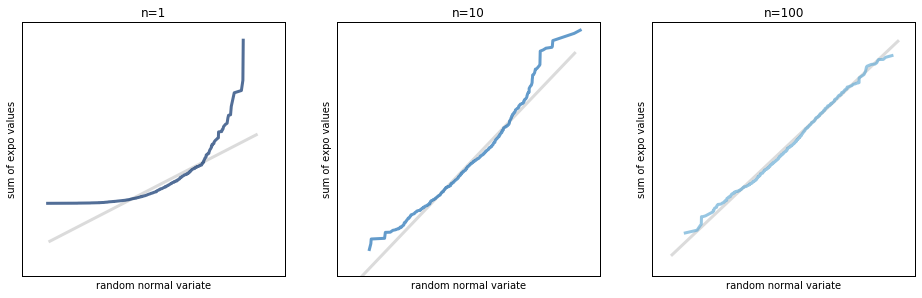

In [10]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeExpoSamples()
NormalPlotSamples(samples, plot=1,
                  ylabel='sum of expo values')

Repeat the analysis with a lognormal distribution:

In [11]:
def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

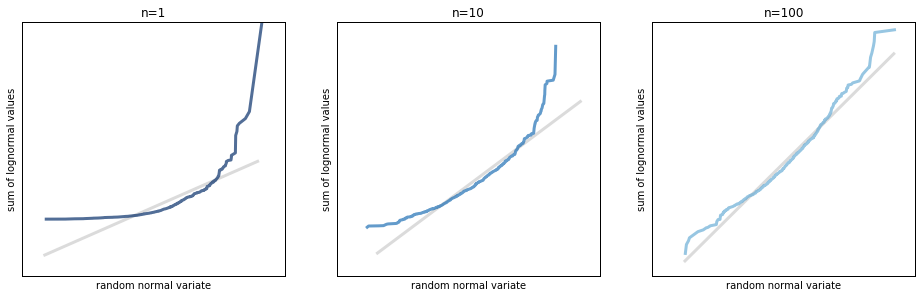

In [12]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeLognormalSamples()
NormalPlotSamples(samples, ylabel='sum of lognormal values')

I also mentioned that CLT does not apply if the values are correlated. To test that, I generate correlated values from an exponential distribution. The algorithm for generating correlated values is (1) generate correlated normal
values, (2) use the normal CDF to transform the values to uniform, and (3) use the inverse exponential CDF to transform the uniform values to exponential.

`GenerateCorrelated` returns an iterator of n normal values with serial correlation rho:

In [ ]:
def GenerateCorrelated(rho, n):
    x = random.gauss(0, 1)
    yield x
    
    sigma = math.sqrt(1 - rho**2)
    for _ in range(n-1):
        x = random.gauss(x*rho, sigma)
        yield x

The first value is a standard normal value. Each subsequent value depends on its predecessor: if the previous value is x, the mean of the next value is x*rho, with variance 1-rho**2. Note that random.gauss takes the standard deviation as the second argument, not variance.

GenerateExpoCorrelated takes the resulting sequence and transforms it to
exponential:

In [9]:
def GenerateExpoCorrelated(rho, n):
    normal = list(GenerateCorrelated(rho, n))
    uniform = scipy.stats.norm.cdf(normal)
    expo = scipy.stats.expon.ppf(uniform)
    return expo

normal is a list of correlated normal values. uniform is a sequence of uniform values between 0 and 1. expo is a correlated sequence of exponential values. ppf stands for “percent point function,” which is another name for the inverse CDF.

explore the normal plots of GenerateExpoCorrelated(rho, n).

These experiments are meant to show how the Central Limit Theorem works, and what happens when it doesn’t. Now let’s see how we can use it.

## Applying the CLT

To see why the Central Limit Theorem is useful, let’s get back to the example in Section 9.3: testing the apparent difference in mean pregnancy length for first babies and others. As we’ve seen, the apparent difference is about 0.078 weeks:

In [ ]:
from Resources.Think_Stats.Thinkstats2 import first

In [ ]:
live, firsts, others = first.MakeFrames()
delta = firsts.prglngth.mean() - others.prglngth.mean()
delta

Remember the logic of hypothesis testing: we compute a p-value, which is the probability of the observed difference under the null hypothesis; if it is small, we conclude that the observed difference is unlikely to be due to chance.

In this example, the null hypothesis is that the distribution of pregnancy lengths is the same for first babies and others. So we can compute the sampling distribution of the mean:

In [20]:
def SamplingDistMean(data, n):
    """Computes the sampling distribution of the mean.

    data: sequence of values representing the population
    n: sample size

    returns: Normal object
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

Here are the sampling distributions for the means of the two groups under the null hypothesis.

In [21]:
dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))

Both sampling distributions are based on the same population, which is the pool of all live births. SamplingDistMean takes this sequence of values and the sample size, and returns a Normal object representing the sampling distribution:

In [12]:
def SamplingDistMean(data, n):
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

mean and var are the mean and variance of data. We approximate the distribution of the data with a normal distribution, dist.

In this example, the data are not normally distributed, so this approximation is not very good. But then we compute dist.Sum(n) / n, which is the sampling distribution of the mean of n values. Even if the data are not normally distributed, the sampling distribution of the mean is, by the Central Limit Theorem.

Next, we compute the sampling distribution of the difference in the means. The Normal class knows how to perform subtraction using Equation 2:
```python
def __sub__(self, other):
    return Normal(self.mu - other.mu,
    self.sigma2 + other.sigma2)```

So we can compute the sampling distribution of the difference like this:

In [ ]:
dist = dist1 - dist2

The mean is 0, which makes sense because we expect two samples from the same distribution to have the same mean, on average. The variance of the sampling distribution is 0.0032.

Normal provides Prob, which evaluates the normal CDF. We can use Prob to compute the probability of a difference as large as delta under the null hypothesis:

In [ ]:
1 - dist.Prob(delta)

Which means that the p-value for a one-sided test is 0.84. For a two-sided test we would also compute

In [ ]:
dist.Prob(-delta)

Which is the same because the normal distribution is symmetric. The sum of the tails is 0.168, which is consistent with the estimate in Section 9.3, which was 0.17.

## Correlation test   

In Section 9.5 we used a permutation test for the correlation between birth weight and mother’s age, and found that it is statistically significant, with p-value less than 0.001.

Now we can do the same thing analytically. The method is based on this mathematical result: given two variables that are normally distributed and uncorrelated, if we generate a sample with size n, compute Pearson’s corre-
lation, r, and then compute the transformed correlation:

![alt text](Resources/Think_Stats/notebookpics/correltaion_test.png "Title")

the distribution of t is Student’s t-distribution with parameter n − 2. The t-distribution is an analytic distribution; the CDF can be computed efficiently using gamma functions.

We can use this result to compute the sampling distribution of correlation under the null hypothesis; that is, if we generate uncorrelated sequences of normal values, what is the distribution of their correlation? StudentCdf
takes the sample size, n, and returns the sampling distribution of correlation:

In [ ]:
def StudentCdf(n):
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return thinkstats2.Cdf(rs, ps)

ts is a NumPy array of values for t, the transformed correlation. ps contains the corresponding probabilities, computed using the CDF of the Student’s t-distribution implemented in SciPy. The parameter of the t-distribution, df, stands for “degrees of freedom.” I won’t explain that term, but you can read about it at http://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics). To get from ts to the correlation coefficients, rs, we apply the inverse transform:

![alt text](Resources/Think_Stats/notebookpics/transform_t.png "Title")

The result is the sampling distribution of r under the null hypothesis.

In [14]:
def ResampleCorrelations(live):
    """Tests the correlation between birth weight and mother's age.

    live: DataFrame for live births

    returns: sample size, observed correlation, CDF of resampled correlations
    """
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf

In [ ]:
n, r, cdf = ResampleCorrelations(live)

model = StudentCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray',
               alpha=0.5, label='Student t')
thinkplot.Cdf(cdf, label='sample')

thinkplot.Config(xlabel='correlation',
                 ylabel='CDF',
                 legend=True, loc='lower right')

this distribution along with the distribution we generated in Section 9.5 by resampling. They are nearly identical. Although the actual distributions are not normal, Pearson’s coefficient of correlation is based on sample means and variances. By the Central Limit Theorem, these momentbased statistics are normally distributed even if the data are not.

we can see that the observed correlation, 0.07, is unlikely to occur if the variables are actually uncorrelated. Using the analytic distribution, we can compute just how unlikely:  

In [ ]:
t = r * math.sqrt((n-2) / (1-r**2))
p_value = 1 - scipy.stats.t.cdf(t, df=n-2)

We compute the value of t that corresponds to r=0.07, and then evaluate the t-distribution at t. The result is 2.9e-11. This example demonstrates an advantage of the analytic method: we can compute very small p-values. But in practice it usually doesn’t matter.

## Chi-squared test

In Section 9.7 we used the chi-squared statistic to test whether a die is crooked. The chi-squared statistic measures the total normalized deviation from the expected values in a table:

![alt text](Resources/Think_Stats/notebookpics/chi_squared.png "Title")

One reason the chi-squared statistic is widely used is that its sampling distribution under the null hypothesis is analytic; by a remarkable coincidence, it is called the chi-squared distribution. Like the t-distribution, the chi-squared CDF can be computed efficiently using gamma functions.

SciPy provides an implementation of the chi-squared distribution, which we use to compute the sampling distribution of the chi-squared statistic:

In [16]:
def ChiSquaredCdf(n):
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n-1)
    return thinkstats2.Cdf(xs, ps)

We can use this distribution to compute the p-value of the observed test statistic, chi2:

In [ ]:
p_value = 1 - scipy.stats.chi2.cdf(chi2, df=n-1)

The parameter of the chi-squared distribution is “degrees of freedom” again. In this case the correct parameter is n-1, where n is the size of the table. Choosing this parameter can be tricky; to be honest, I am never confident
that I have it right until I generate something like Figure 14.4 to compare the analytic results to the resampling results.

In [ ]:
data = [8, 9, 19, 5, 8, 11]
dt = hypothesis.DiceChiTest(data)
p_value = dt.PValue(iters=1000)
n, chi2, cdf = len(data), dt.actual, dt.test_cdf

model = ChiSquaredCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray',
                   alpha=0.3, label='chi squared')
thinkplot.Cdf(cdf, label='sample')

thinkplot.Config(xlabel='chi-squared statistic',
                 ylabel='CDF',
                 loc='lower right')

## Discussion

This book focuses on computational methods like resampling and permutation. These methods have several advantages over analysis:

- They are easier to explain and understand. For example, one of the most difficult topics in an introductory statistics class is hypothesis testing. Many students don’t really understand what p-values are. I think the approach I presented in Chapter 9—simulating the null hypothesis and computing test statistics—makes the fundamental idea clearer.
- They are robust and versatile. Analytic methods are often based on assumptions that might not hold in practice. Computational methods require fewer assumptions, and can be adapted and extended more easily.
- They are debuggable. Analytic methods are often like a black box: you plug in numbers and they spit out results. But it’s easy to make subtle errors, hard to be confident that the results are right, and hard to find the problem if they are not. Computational methods lend themselves to incremental development and testing, which fosters confidence in the results.

But there is one drawback: computational methods can be slow. Taking into account these pros and cons, I recommend the following process:
1. Use computational methods during exploration. If you find a satisfactory answer and the run time is acceptable, you can stop.
2. If run time is not acceptable, look for opportunities to optimize. Using analytic methods is one of several methods of optimization.
3. If replacing a computational method with an analytic method is appropriate, use the computational method as a basis of comparison, providing mutual validation between the computational and analytic results.

For the vast majority of problems I have worked on, I didn’t have to go past Step 1.